# Split into Train/ Valid/ Test set

## Load Dataset from sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [3]:
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


---
## Convert to PyTorch Tensor

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [26]:
## Train/ Valid/ Test ratio

ratios = [.6, .2, .2]

In [27]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print(f"Train {train_cnt}/ Valid {valid_cnt}/ Test {test_cnt}")

Train 12384/ Valid 4128/ Test 4128


In [28]:
## Shuffle before split.

indices = torch.randperm(data.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# split train, valid and test set with each count.
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


---
## Preprocessing

In [29]:
scaler = StandardScaler()
scaler.fit(x[0].numpy()) # You must fit with train data only.

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

df = pd.DataFrame(x[0].numpy(), columns=california.feature_names)
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12379,0.291200,-0.287476,-0.145183,-0.183682,-0.185719,-0.056738,-0.849702,0.623880
12380,0.961767,0.349222,0.191670,-0.158284,-0.552502,-0.005673,0.808099,-1.202917
12381,0.761771,-1.640459,0.216569,-0.300304,-0.297543,-0.027169,1.107814,-1.103090
12382,-0.663158,1.304270,-0.487685,-0.386881,-1.196608,-0.018457,-0.770089,1.108032
12383,-0.758647,-0.924174,0.016029,0.006429,0.486119,-0.011819,1.763442,-0.943370


---
## Build Model & Optimizer

In [43]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [44]:
optimizer = optim.Adam(model.parameters())

---
## Train

In [45]:
n_epochs = 2000
batch_size = 256
print_interval = 100

In [46]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 100
lowest_epoch = np.inf

In [47]:
train_history, valid_history = [], []

for i in range(n_epochs):
    # Shuffle before mini-batch split.
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    # |x_| = (total_size, input_dim)
    # |y_| = (total_size, output_dim)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    # |x_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        # |x_i| = |x_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss += float(loss)
        
    train_loss = train_loss / len(x_)
    
    # You need to declare to PYTORCH to stop build the computational graph
    with torch.no_grad():
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)
            
            valid_loss += loss
            
            y_hat += [y_hat_i]
            
        valid_loss = valid_loss / len(x_)
        
        # Log each loss to plot after training is done.
        train_history += [train_loss]
        valid_history += [valid_loss]
        
        if (i + 1) % print_interval == 0:
            print(f"Epoch {i + 1}: train loss={train_loss:.4f} valid_loss={valid_loss:.4f} lowest_loss={lowest_loss:.4f}")
            
        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i
            
            # 'state_dict()' returns model weights as key-value.
            # Take a deep copy, if the valid loss is lowest ever.
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i:
                print(f"There is no improvement during last {early_stop} epochs.")
                break
            
print(f"The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.4f}")


Epoch 100: train loss=0.3470 valid_loss=0.3675 lowest_loss=0.3662
Epoch 200: train loss=0.3384 valid_loss=0.3560 lowest_loss=0.3541
Epoch 300: train loss=0.3148 valid_loss=0.3336 lowest_loss=0.3325
Epoch 400: train loss=0.3104 valid_loss=0.3256 lowest_loss=0.3252
Epoch 500: train loss=0.3083 valid_loss=0.3249 lowest_loss=0.3236
Epoch 600: train loss=0.3062 valid_loss=0.3230 lowest_loss=0.3227
Epoch 700: train loss=0.3055 valid_loss=0.3220 lowest_loss=0.3219
Epoch 800: train loss=0.2973 valid_loss=0.3192 lowest_loss=0.3179
Epoch 900: train loss=0.2939 valid_loss=0.3131 lowest_loss=0.3135
Epoch 1000: train loss=0.2917 valid_loss=0.3124 lowest_loss=0.3106
Epoch 1100: train loss=0.2918 valid_loss=0.3115 lowest_loss=0.3104
There is no improvement during last 100 epochs.
The best validation loss from epoch 1057: 0.3104


In [48]:
model.load_state_dict(best_model)

<All keys matched successfully>

---
## Loss History

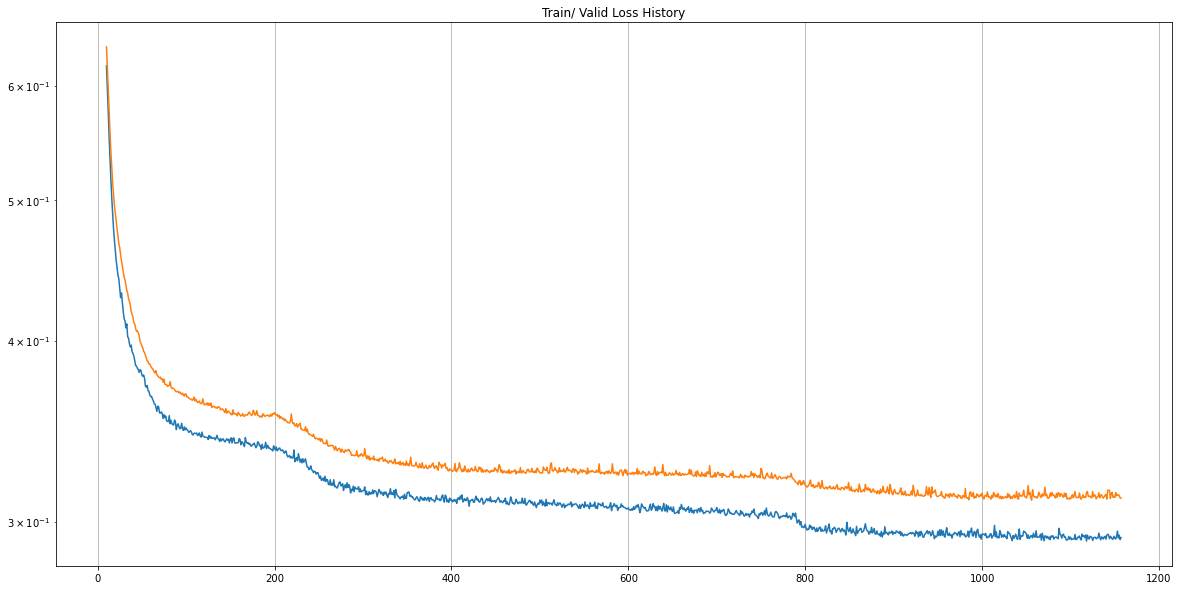

In [53]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train/ Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

---
## Result

In [54]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        test_loss += loss ## Gradient is already detached.
        
        y_hat += [y_hat_i]
    
test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

In [62]:
a = [5, 2, 3, 1, 4]
b = [8, 10, 5, 11, 6]

sorted(zip(a, b), key=lambda x: x[1])[0][1]

5

In [63]:
sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f"Train loss: {sorted_history[0][0]:.4f}")
print(f"Valid loss: {sorted_history[0][1]:.4f}")
print(f"Test loss: {test_loss:.4f}")

Train loss: 0.2933
Valid loss: 0.3104
Test loss: 0.3123


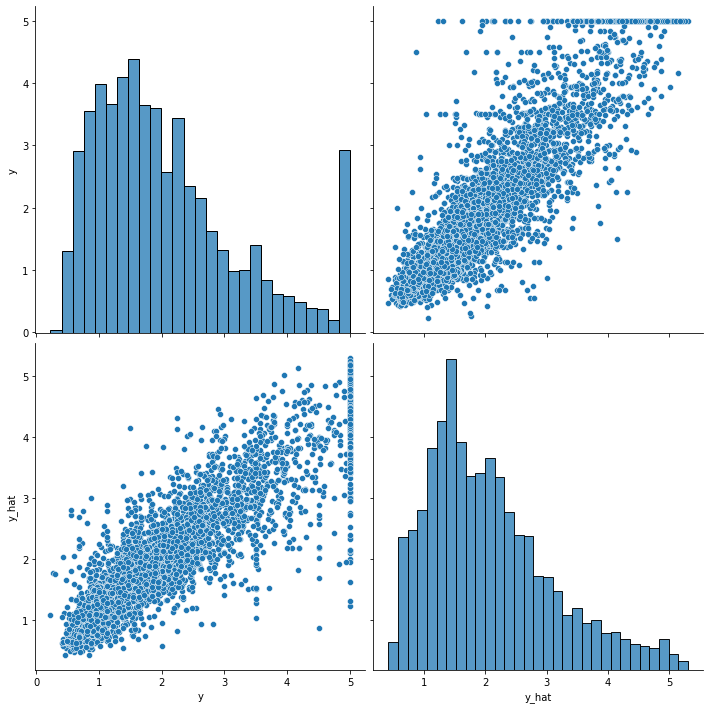

In [65]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=['y', 'y_hat'])
sns.pairplot(df, height=5)
plt.show()